In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import pandas as pd
from tqdm import trange
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from google.colab import drive

In [0]:
## Mount Drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
## create custom Model via keras
class MatrixFactorizor(tf.keras.Model):
  def __init__(self,embed_size):
    super(MatrixFactorizor, self).__init__()
    self.embed_size=embed_size
    self.MF=MFlayer(embed_size=self.embed_size)
    self.step_func=tf.keras.activations.relu
  
  def call(self,input):
    output=self.MF(input)
    output=self.step_func(output)
    return output

## custom layer via keras
class MFlayer(tf.keras.layers.Layer):

  def __init__(self,embed_size):
    super(MFlayer,self).__init__()
    self.embed_size=embed_size
  
  def build(self,input_size):
    len_user,len_item=input_size
    ## init user latent=random tensor from gaussian dist.
    self.user_latent=self.add_weight("user_latent",shape=[len_user,self.embed_size],dtype=tf.float32,initializer=tf.initializers.RandomNormal)
    ## init item latent=random tensor from gaussian dist.
    self.item_latent=self.add_weight("item_latent",shape=[self.embed_size,len_item],dtype=tf.float32,initializer=tf.initializers.RandomNormal)
    ## init bias unique for the user and same for item
    self.user_bias=self.add_weight("user_bias",shape=[len_user],dtype=tf.float32,initializer=tf.initializers.Zeros)
    ## init bias unique for the item and same for user
    self.item_bias=self.add_weight("item_bias",shape=[len_item],dtype=tf.float32,initializer=tf.initializers.Zeros)
    ## init bias unique for the item and same for user
    self.global_bias=self.add_weight("global_bias",shape=[],dtype=tf.float32,initializer=tf.initializers.Zeros)

  def call(self,input):
    return tf.add(tf.add(tf.matmul(self.user_latent,self.item_latent),tf.expand_dims(self.user_bias,axis=1)),tf.expand_dims(self.item_bias,axis=0)+self.global_bias)

## cost func
def cost_fn(source, target,regularizer):
  mse = tf.keras.losses.MeanSquaredError()
  cost = mse(source, target)
  return tf.add(cost,regularizer)

def get_userLatent(model):
    return model.weights[0]

def get_itemLatent(model):
    return model.weights[1]

def mse(source, target):
  mse = tf.keras.losses.MeanSquaredError()
  loss = mse(source, target)
  return loss


In [0]:
### Load Data
expli_train=pd.read_csv("/content/drive/Shared drives/Chula Drive/Datasets/AnimeRec-w  review/train_expli_matrix")
expli_train=expli_train.set_index("uid")
expli_test=pd.read_csv("/content/drive/Shared drives/Chula Drive/Datasets/AnimeRec-w  review/test_expli_matrix")
expli_test=expli_test.set_index("uid")

embed_size=6

model=MatrixFactorizor(embed_size=embed_size)
model.build(expli_train.shape)

In [0]:
model.summary()

Model: "matrix_factorizor_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
m_flayer_1 (MFlayer)         multiple                  224750    
Total params: 224,750
Trainable params: 224,750
Non-trainable params: 0
_________________________________________________________________


In [0]:
voted_train=tf.gather(expli_train.values.flatten(),indices=np.where(expli_train.values.flatten()>0))
voted_train

<tf.Tensor: shape=(1, 28554), dtype=int64, numpy=array([[10,  8, 10, ..., 10,  9, 10]])>

epoch:   0%|          | 1/500 [00:00<03:53,  2.13it/s]

step: 0,loss: 51.67245


epoch:  20%|██        | 101/500 [00:46<03:01,  2.19it/s]

step: 100,loss: 1.3820761


epoch:  40%|████      | 201/500 [01:32<02:18,  2.16it/s]

step: 200,loss: 1.1042273


epoch:  60%|██████    | 301/500 [02:17<01:31,  2.18it/s]

step: 300,loss: 1.1212059


epoch:  80%|████████  | 401/500 [03:03<00:45,  2.17it/s]

step: 400,loss: 1.2231749


epoch: 100%|██████████| 500/500 [03:49<00:00,  2.18it/s]


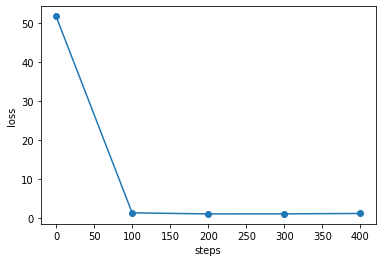

In [0]:
### save to plot
losses=[]
steps=[]

### train (trange is just range with progress bar from tqdm module)

optimizer=tf.optimizers.Adam(learning_rate=0.05)
for i in trange(500, desc="epoch"):
   with tf.GradientTape() as tape:
    predicted=model(expli_train)
    voted_train_predicted=tf.gather(tf.reshape(predicted,[-1]),indices=np.where(expli_train.values.flatten()>0))
    regularize=tf.multiply(tf.add(tf.reduce_sum(tf.abs(get_userLatent(model))),tf.reduce_sum(tf.abs(get_itemLatent(model)))),0.001)
    loss=cost_fn(voted_train,voted_train_predicted,regularize)
    if i%100==0:
      losses.append(loss.numpy())
      steps.append(i)
      print("step: "+str(i)+",loss: "+str(loss.numpy()))
   variables=model.trainable_weights
   gradient=tape.gradient(loss,variables)
   optimizer.apply_gradients(zip(gradient,variables))

# plot training loss
plt.plot(steps, losses, marker="o")
plt.xlabel("steps")
plt.ylabel("loss")
plt.show()

In [0]:
test_value=expli_test.values.flatten()
voted_test_val=tf.gather(test_value,indices=np.where(test_value>0))
predicted=model(expli_train)
predicted_test=tf.gather(tf.reshape(predicted,[-1]),indices=np.where(test_value>0))

mse(voted_test_val,predicted_test).numpy()

8.00042

In [0]:
predicted_test

<tf.Tensor: shape=(1, 8909), dtype=float32, numpy=
array([[9.558413 , 7.1410494, 7.141265 , ..., 5.3226366, 7.637968 ,
        7.145439 ]], dtype=float32)>

In [0]:
voted_test_val

<tf.Tensor: shape=(1, 8909), dtype=int64, numpy=array([[10,  7, 10, ..., 10, 10, 10]])>